In [1]:
import xarray as xr
import pandas as pd
from prophet import Prophet
import cftime
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler


# Extracting data 

In [2]:
file_paths = ['CDS_Data/data_stream-wave_stepType-instant.nc', 'CDS_Data/data_stream-oper_stepType-instant.nc', 
           'CDS_Data/data_stream-oper_stepType-accum.nc']

# Create an empty list to store the Datasets
datasets = []

# Open each NetCDF file and append its Dataset to the list
for fp in file_paths:
    ds = xr.open_dataset(fp)
    datasets.append(ds)

# Merge all Datasets in the list into a single Dataset
combined_dataset = xr.merge(datasets)

# Inspect your dataset
print(combined_dataset)

<xarray.Dataset> Size: 17GB
Dimensions:     (valid_time: 365, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2002-01-01T12:00:00 ... 2002-...
  * latitude    (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 8B 0
    expver      (valid_time) <U4 6kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    mwd         (valid_time, latitude, longitude) float32 2GB nan nan ... nan
    mwp         (valid_time, latitude, longitude) float32 2GB nan nan ... nan
    swh         (valid_time, latitude, longitude) float32 2GB nan nan ... nan
    u10         (valid_time, latitude, longitude) float32 2GB ...
    v10         (valid_time, latitude, longitude) float32 2GB ...
    d2m         (valid_time, latitude, longitude) float32 2GB ...
    t2m         (valid_time, latitude, longitude) float32 2GB ...
    msl         (valid_time, latitud

In [3]:
print("--- Checking Latitude Coordinates ---")
print(combined_dataset['latitude'])
print(f"Minimum Latitude: {combined_dataset['latitude'].min().item()}")
print(f"Maximum Latitude: {combined_dataset['latitude'].max().item()}")

print("\n--- Checking Longitude Coordinates ---")
print(combined_dataset['longitude'])
print(f"Minimum Longitude: {combined_dataset['longitude'].min().item()}")
print(f"Maximum Longitude: {combined_dataset['longitude'].max().item()}")

print("\n--- Full Dataset Info ---")
print(combined_dataset) # Look closely at the dimensions here too.


--- Checking Latitude Coordinates ---
<xarray.DataArray 'latitude' (latitude: 721)> Size: 6kB
array([-90.  , -89.75, -89.5 , ...,  89.5 ,  89.75,  90.  ])
Coordinates:
  * latitude  (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
    number    int64 8B 0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing
Minimum Latitude: -90.0
Maximum Latitude: 90.0

--- Checking Longitude Coordinates ---
<xarray.DataArray 'longitude' (longitude: 1440)> Size: 12kB
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02])
Coordinates:
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number     int64 8B 0
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude
Minimum Longitude: 0.0
Maximum Longitude: 359.75

--- Full Dataset Info ---
<xarray.Dataset> Size: 17GB
Dimensions:     (

In [4]:
north_bound_lat_chch = 55.0  # Remember: -43.0 is "more north" than -44.0
south_bound_lat_chch = 45.0
west_bound_lon_chch = 5.0
east_bound_lon_chch = 20.0

# 1. Select the data for the specified Christchurch region
# IMPORTANT: For 'latitude' which is 'decreasing' (90 to -90), the slice order is (higher_value, lower_value)
ds = combined_dataset.sel(
    latitude=slice(south_bound_lat_chch, north_bound_lat_chch), # Correct order for decreasing latitude
    longitude=slice(west_bound_lon_chch, east_bound_lon_chch)   # Standard order for increasing longitude (0 to 359.5)
)

print(ds)

<xarray.Dataset> Size: 40MB
Dimensions:     (valid_time: 365, latitude: 41, longitude: 61)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 2002-01-01T12:00:00 ... 2002-...
  * latitude    (latitude) float64 328B 45.0 45.25 45.5 ... 54.5 54.75 55.0
  * longitude   (longitude) float64 488B 5.0 5.25 5.5 5.75 ... 19.5 19.75 20.0
    number      int64 8B 0
    expver      (valid_time) <U4 6kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    mwd         (valid_time, latitude, longitude) float32 4MB nan nan ... 344.9
    mwp         (valid_time, latitude, longitude) float32 4MB nan nan ... 6.452
    swh         (valid_time, latitude, longitude) float32 4MB nan nan ... 2.092
    u10         (valid_time, latitude, longitude) float32 4MB ...
    v10         (valid_time, latitude, longitude) float32 4MB ...
    d2m         (valid_time, latitude, longitude) float32 4MB ...
    t2m         (valid_time, latitude, longitude) float32 4MB ...
    msl         (valid_time, latitude

In [5]:
df = ds.to_dataframe()
print(df)


                                        number expver         mwd       mwp  \
valid_time          latitude longitude                                        
2002-01-01 12:00:00 45.0     5.00            0   0001         NaN       NaN   
                             5.25            0   0001         NaN       NaN   
                             5.50            0   0001         NaN       NaN   
                             5.75            0   0001         NaN       NaN   
                             6.00            0   0001         NaN       NaN   
...                                        ...    ...         ...       ...   
2002-12-31 12:00:00 55.0     19.00           0   0001  351.784027  6.344384   
                             19.25           0   0001         NaN       NaN   
                             19.50           0   0001  347.205902  6.363671   
                             19.75           0   0001         NaN       NaN   
                             20.00           0   000

# Addressing NaNs in the data

In [6]:
print("\nNaN counts per column in DataFrame:")
print(df.isnull().sum())


NaN counts per column in DataFrame:
number         0
expver         0
mwd       884395
mwp       884395
swh       884395
u10            0
v10            0
d2m            0
t2m            0
msl            0
sst       821250
sp             0
tp             0
dtype: int64


In [7]:
# List of columns to drop
columns_to_drop = ['mwd', 'mwp', 'swh', 'sst']

# Drop the columns
df_cleaned = df.drop(columns=columns_to_drop)

print(print(df_cleaned.isnull().sum()))

number    0
expver    0
u10       0
v10       0
d2m       0
t2m       0
msl       0
sp        0
tp        0
dtype: int64
None


/var/folders/sc/3q0dn98n3650g9d83vqnmpzs5hfw1p/T/ipykernel_1848/175617088.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['tp_mm'][df['tp_mm'] < 0] = 0
/var/folders/sc/3q0dn98n3650g9d83vqnmpzs5hfw1p/T/ipykernel_1848/175617088.py:19: 

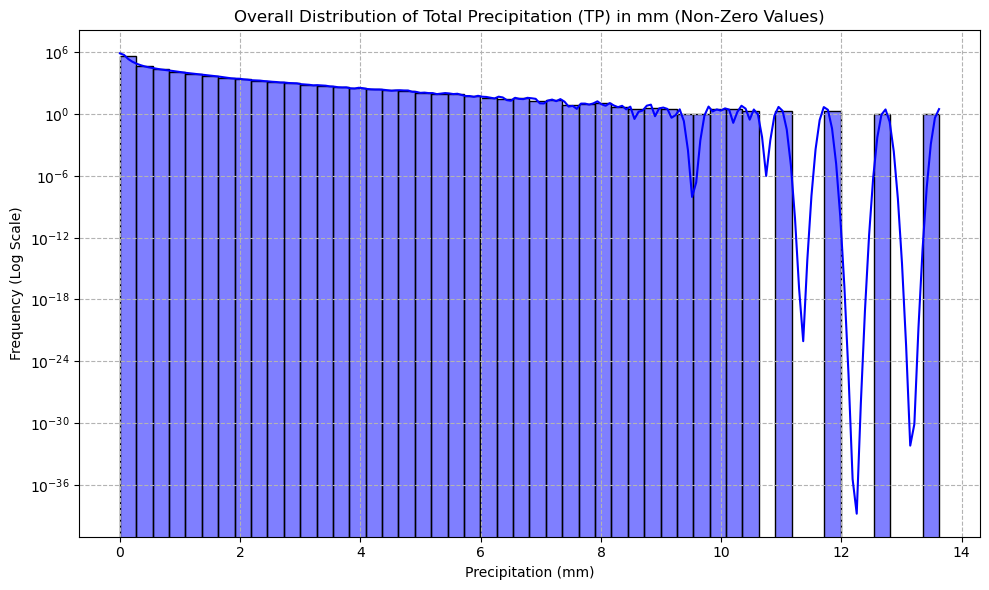

Overall TP (mm) - Min: 0.0, Max: 13.622283935546875, Median: 0.00762939453125
Percentage of zero precipitation values: 36.36%


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure 'valid_time' is a proper datetime index if it's not already
if not isinstance(df.index, pd.MultiIndex) or 'valid_time' not in df.index.names:
    # If df is not multi-indexed by valid_time, latitude, longitude
    # Or if valid_time is not a datetime type, convert it.
    # This step might vary depending on how df was created from ds
    # Assuming valid_time is already the first level of the MultiIndex:
    df.index = df.index.set_levels(pd.to_datetime(df.index.levels[0]), level='valid_time')


# Convert 'tp' from meters to millimeters
df['tp_mm'] = df['tp'] * 1000

# Handle potential negative values (if any result from conversion/interpolation)
df['tp_mm'][df['tp_mm'] < 0] = 0

# You might want to drop rows with NaNs for some variables for analysis
# For 'tp_mm', NaNs are less common if original 'tp' was always a number
# For other variables like 'mwd', 'mwp', 'swh', 'sst', many NaNs exist.
# Example: df_clean = df.dropna(subset=['tp_mm', 'u10', 'v10', 't2m'])

plt.figure(figsize=(10, 6))
# Filter for non-zero precipitation for a clearer view of actual rainfall events
sns.histplot(df['tp_mm'][df['tp_mm'] > 0], bins=50, kde=True, color='blue')
plt.title('Overall Distribution of Total Precipitation (TP) in mm (Non-Zero Values)')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency (Log Scale)')
plt.yscale('log') # Use log scale for y-axis to better visualize skewed data
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.show()

print(f"Overall TP (mm) - Min: {df['tp_mm'].min()}, Max: {df['tp_mm'].max()}, Median: {df['tp_mm'].median()}")
print(f"Percentage of zero precipitation values: {np.mean(df['tp_mm'] == 0) * 100:.2f}%")



# Train/test split

In [9]:
df_reset = df_cleaned.reset_index()

# Convert 'valid_time' to datetime
df_reset['valid_time'] = pd.to_datetime(df_reset['valid_time'])

# Sort by time, then latitude, then longitude to ensure consistent grid formation
df_sorted = df_reset.sort_values(by=['valid_time', 'latitude', 'longitude'])

# Re-set the MultiIndex for easier handling, though we might iterate through it
df_final = df_sorted.set_index(['valid_time', 'latitude', 'longitude'])

print("DataFrame after sorting and re-indexing (first few rows):")
print(df_final.head())
print(f"Original shape: {df_final.shape}")



DataFrame after sorting and re-indexing (first few rows):
                                        number expver       u10       v10  \
valid_time          latitude longitude                                      
2002-01-01 12:00:00 45.0     5.00            0   0001 -0.804764 -1.102310   
                             5.25            0   0001 -0.738358 -0.229263   
                             5.50            0   0001 -0.763748  0.397690   
                             5.75            0   0001 -1.006912  0.909409   
                             6.00            0   0001 -1.389725  0.598862   

                                               d2m         t2m         msl  \
valid_time          latitude longitude                                       
2002-01-01 12:00:00 45.0     5.00       267.758881  274.061951  103693.125   
                             5.25       266.268646  273.729919  103658.125   
                             5.50       265.891693  271.888123  103644.625   
            

In [10]:
# --- 2. Determine Grid Dimensions ---
# Get unique latitudes and longitudes
latitudes = df_final.index.get_level_values('latitude').unique().sort_values()
longitudes = df_final.index.get_level_values('longitude').unique().sort_values()

num_lat = len(latitudes)
num_lon = len(longitudes)
num_features = len(df_final.columns) # All columns are features except if we designate one as target later

print(f"\nGrid dimensions: Latitude={num_lat}, Longitude={num_lon}")
print(f"Number of features (variables): {num_features}")



Grid dimensions: Latitude=41, Longitude=61
Number of features (variables): 9


In [11]:
# --- 3. Reshape to Gridded Data (Time, Lat, Lon, Features) ---
# Get all unique timestamps
all_times = df_final.index.get_level_values('valid_time').unique().sort_values()
num_times = len(all_times)

# Create an empty array to store the gridded data
# Shape: (num_times, num_lat, num_lon, num_features)
gridded_data = np.full((num_times, num_lat, num_lon, num_features), np.nan) # Use nan for missing spots

# Map latitude and longitude to array indices
lat_to_idx = {lat: i for i, lat in enumerate(latitudes)}
lon_to_idx = {lon: i for i, lon in enumerate(longitudes)}

# Populate the gridded_data array
for t_idx, time in enumerate(all_times):
    # Select data for the current timestamp
    time_slice_df = df_final.loc[time]

    for (lat, lon), row_data in time_slice_df.iterrows():
        lat_idx = lat_to_idx[lat]
        lon_idx = lon_to_idx[lon]
        gridded_data[t_idx, lat_idx, lon_idx, :] = row_data.values

print(f"\nShape of gridded_data: {gridded_data.shape}")
# Check if there are any NaNs left from this reshaping.
# There shouldn't be if all combinations of lat/lon exist for each time.
print(f"NaNs in gridded data after initial reshape: {np.sum(np.isnan(gridded_data))}")



Shape of gridded_data: (365, 41, 61, 9)
NaNs in gridded data after initial reshape: 0


In [12]:
# --- 4. Define Input (X) and Target (y) Variables ---
# 'tp' is total precipitation, which we want to predict.
# Let's find its column index.
feature_names = df_final.columns.tolist()
tp_col_idx = feature_names.index('tp')


In [13]:
# --- 5. Create Sequences for ConvLSTM ---
# We need to define:
# - `n_steps_in`: how many past time steps to use as input
# - `n_steps_out`: how many future time steps to predict (for rainfall, often 1)

n_steps_in = 3  # Example: Use the past 3 time steps (e.g., 3 days if data is daily)
n_steps_out = 1 # Example: Predict the next 1 time step (e.g., next day's rainfall)

def create_sequences(data, n_steps_in, n_steps_out, tp_idx):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        # Input sequence (all features except 'tp' for n_steps_in)
        # We need to exclude 'tp' from the input features
        X_seq_features = np.delete(data[i:(i + n_steps_in)], tp_idx, axis=-1)
        X.append(X_seq_features)

        # Output sequence (only 'tp' for n_steps_out)
        y_seq_tp = data[(i + n_steps_in):(i + n_steps_in + n_steps_out), :, :, tp_idx]
        y.append(y_seq_tp)
    return np.array(X), np.array(y)

X_sequences, y_sequences = create_sequences(gridded_data, n_steps_in, n_steps_out, tp_col_idx)

print(f"\nShape of X_sequences (input): {X_sequences.shape}")
print(f"Shape of y_sequences (target): {y_sequences.shape}")

# X_sequences shape should be (num_samples, n_steps_in, num_lat, num_lon, num_features - 1)
# y_sequences shape should be (num_samples, n_steps_out, num_lat, num_lon) - if predicting one variable




Shape of X_sequences (input): (362, 3, 41, 61, 8)
Shape of y_sequences (target): (362, 1, 41, 61)


In [14]:
# --- 6. Time-based Train-Test Split ---
# The data covers 2002. Let's use the first ~9 months for training and the last ~3 months for testing.
# A common split is 80% train / 20% test.
# Since X_sequences and y_sequences are already ordered by time, we can simply split the arrays.

# Determine the split point based on the number of sequences
split_ratio = 0.8
split_index = int(len(X_sequences) * split_ratio)

X_train = X_sequences[:split_index]
y_train = y_sequences[:split_index]
X_test = X_sequences[split_index:]
y_test = y_sequences[split_index:]

print(f"\nTraining set size: {len(X_train)} sequences")
print(f"Test set size: {len(X_test)} sequences")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



Training set size: 289 sequences
Test set size: 73 sequences
X_train shape: (289, 3, 41, 61, 8)
y_train shape: (289, 1, 41, 61)
X_test shape: (73, 3, 41, 61, 8)
y_test shape: (73, 1, 41, 61)


# Normalisation

In [15]:
original_feature_names_in_X_sequences = [col for col in df_final.columns if col != 'tp']


print(f"Features (channels) in X_sequences before normalization: {original_feature_names_in_X_sequences}")
print(f"Number of features (channels) in X_sequences: {len(original_feature_names_in_X_sequences)}")


Features (channels) in X_sequences before normalization: ['number', 'expver', 'u10', 'v10', 'd2m', 't2m', 'msl', 'sp']
Number of features (channels) in X_sequences: 8


In [16]:
# --- 1. Identify and Exclude Constant Features (if any) ---
# This step should ideally be done BEFORE creating X_sequences.
# Let's check for constants in the original `df_final` used to create the gridded data.
# If df_final is not available, you would need to load a sample or assume.

constant_features_found = []
if 'df_final' in locals():
    # Check only features that ended up in X_sequences
    for col in original_feature_names_in_X_sequences:
        if df_final[col].nunique() == 1:
            constant_features_found.append(col)
            print(f"Warning: Feature '{col}' is constant and will not be effectively normalized by RobustScaler.")
            print(f"It's generally recommended to remove constant features before creating sequences if they are truly constant.")
else:
    print("Warning: `df_final` not found. Cannot verify if features are constant.")


It's generally recommended to remove constant features before creating sequences if they are truly constant.
It's generally recommended to remove constant features before creating sequences if they are truly constant.


In [17]:
# --- 2. Normalization of X_train and X_test features ---

# Get the shape of X_train to reshape back later
shape_x_train = X_train.shape # (num_samples, n_steps_in, num_lat, num_lon, num_features_for_scaling)
num_features_for_scaling = shape_x_train[-1] # Number of channels (e.g., 8)

# Flatten X_train for scaler fitting: (total_elements, num_features)
# This combines all samples, timesteps, lat, and lon into a single dimension for feature scaling
X_train_reshaped_for_scaler = X_train.reshape(-1, num_features_for_scaling)
print(f"\nX_train reshaped for scaler fitting: {X_train_reshaped_for_scaler.shape}")

# Initialize RobustScaler for features
scaler_X = RobustScaler()

# Fit the scaler ONLY on the training data's reshaped features
scaler_X.fit(X_train_reshaped_for_scaler)
print("\nRobustScaler for features (X) fitted on X_train data.")

# Transform both training and test data using the fitted scaler
X_train_normalized_reshaped = scaler_X.transform(X_train_reshaped_for_scaler)
X_test_normalized_reshaped = scaler_X.transform(X_test.reshape(-1, num_features_for_scaling)) # Reshape X_test on the fly

print(f"X_train normalized reshaped shape: {X_train_normalized_reshaped.shape}")
print(f"X_test normalized reshaped shape: {X_test_normalized_reshaped.shape}")

# Reshape the normalized data back to the ConvLSTM input format (5D)
X_train_normalized = X_train_normalized_reshaped.reshape(shape_x_train)
X_test_normalized = X_test_normalized_reshaped.reshape(X_test.shape) # Use X_test's original shape

print(f"\nFinal X_train_normalized shape (ready for ConvLSTM input): {X_train_normalized.shape}")
print(f"Final X_test_normalized shape (ready for ConvLSTM input): {X_test_normalized.shape}")




X_train reshaped for scaler fitting: (2168367, 8)

RobustScaler for features (X) fitted on X_train data.
X_train normalized reshaped shape: (2168367, 8)
X_test normalized reshaped shape: (547719, 8)

Final X_train_normalized shape (ready for ConvLSTM input): (289, 3, 41, 61, 8)
Final X_test_normalized shape (ready for ConvLSTM input): (73, 3, 41, 61, 8)


In [18]:
# --- 3. Normalization for the Target Variable (y - Total Precipitation 'tp') ---
# 'tp' values are non-negative and often have a high concentration at zero, with some large values.
# RobustScaler can work, but consider alternatives like log1p if zeros are dominant and you want to reduce skewness.

# Get the shape of y_train to reshape back later
shape_y_train = y_train.shape # (num_samples, n_steps_out, num_lat, num_lon)
num_features_y = 1 # 'tp' is a single target variable

y_train_normalized = np.log1p(y_train)
y_test_normalized = np.log1p(y_test)

print(f"Final y_train_normalized shape (ready for ConvLSTM output): {y_train_normalized.shape}")
print(f"Final y_test_normalized shape (ready for ConvLSTM output): {y_test_normalized.shape}")



Final y_train_normalized shape (ready for ConvLSTM output): (289, 1, 41, 61)
Final y_test_normalized shape (ready for ConvLSTM output): (73, 1, 41, 61)


# Training

In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, Conv2D, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Ensure TensorFlow is using a GPU if available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("Using GPU for training.")
else:
    print("No GPU found. Training on CPU.")

# --- Define Model Parameters based on your data ---
# These values should come from your previous data preparation steps
# For demonstration purposes, I'll use placeholders if not defined globally.
# In a continuous script, these would already be in scope.

# Example values (replace with your actual data shapes from previous steps)
# from the previous notebook section
# X_train_normalized shape: (num_train_samples, n_steps_in, num_lat, num_lon, num_predictor_features)
# y_train_normalized shape: (num_train_samples, n_steps_out, num_lat, num_lon)

# Assume these are available from the previous run:
# X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized

# Infer dimensions from your normalized data
n_samples_train, n_steps_in, num_lat, num_lon, num_channels = X_train_normalized.shape
_, n_steps_out, _, _ = y_train_normalized.shape # Assuming y_train_normalized has 4 dimensions

print(f"\nModel Input Parameters:")
print(f"  n_steps_in (sequence length): {n_steps_in}")
print(f"  num_lat (grid rows): {num_lat}")
print(f"  num_lon (grid columns): {num_lon}")
print(f"  num_channels (input features): {num_channels}")
print(f"  n_steps_out (prediction horizon): {n_steps_out}")

# --- Adjust y_train_normalized/y_test_normalized if n_steps_out is 1 ---
# Keras ConvLSTM2D output can be a sequence or just the last step.
# If n_steps_out is 1, it's common to predict a single frame.
# The target `y` should match the model's output shape.
if n_steps_out == 1:
    # Squeeze the n_steps_out dimension from y if it's 1, as the model's Conv3D output will be 3D.
    # From (samples, 1, lat, lon) to (samples, lat, lon)
    y_train_target = y_train_normalized.squeeze(axis=1)
    y_test_target = y_test_normalized.squeeze(axis=1)
    print(f"Target 'y' adjusted from {y_train_normalized.shape} to {y_train_target.shape} for n_steps_out=1.")
else:
    y_train_target = y_train_normalized
    y_test_target = y_test_normalized
    print(f"Target 'y' shape remains {y_train_target.shape} as n_steps_out > 1.")

# --- Build the ConvLSTM Model ---

model = Sequential()

model.add(ConvLSTM2D(filters=64, kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                     return_sequences=True,
                     input_shape=(n_steps_in, num_lat, num_lon, num_channels)))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                     activation='relu',
                     padding='same',
                     return_sequences=False))
model.add(BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=(1, 1), activation='linear', padding='same'))

if n_steps_out == 1:
    model.add(Lambda(lambda x: tf.squeeze(x, axis=-1)))

# --- Compile the Model ---
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

# --- Define Callbacks for Training ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_convlstm_model.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min',
                                   verbose=1)

# --- Train the Model ---
print("\nStarting model training...")
history = model.fit(X_train_normalized, y_train_target,
                    epochs=50,
                    batch_size=8,
                    validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

print("\nModel training complete.")

# --- Evaluate the Model on the Test Set ---
print("\nEvaluating model on the test set...")
test_loss, test_mae = model.evaluate(X_test_normalized, y_test_target, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# You can now use the trained `model` to make predictions:
# predictions_normalized = model.predict(X_test_normalized)
# Then inverse transform `predictions_normalized` using `scaler_y` to get original precipitation values.


Num GPUs Available:  0
No GPU found. Training on CPU.

Model Input Parameters:
  n_steps_in (sequence length): 3
  num_lat (grid rows): 41
  num_lon (grid columns): 61
  num_channels (input features): 8
  n_steps_out (prediction horizon): 1
Target 'y' adjusted from (289, 1, 41, 61) to (289, 41, 61) for n_steps_out=1.


/Users/ahmed.shaikh/miniforge3/envs/srsi/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 3, 41, 61, 64)  │       461,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 41, 61, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 41, 61, 64)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 41, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 41, 61, 1)      │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 41, 61)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,801 (2.89 MB)

 Trainable params: 756,545 (2.89 MB)

 Non-trainable params: 256 (1.00 KB)


Starting model training...
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.9003 - mae: 0.6101
Epoch 1: val_loss improved from inf to 0.01825, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.8834 - mae: 0.6024 - val_loss: 0.0183 - val_mae: 0.1003
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0372 - mae: 0.1448
Epoch 2: val_loss did not improve from 0.01825
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0370 - mae: 0.1444 - val_loss: 0.0249 - val_mae: 0.1247
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0176 - mae: 0.0941
Epoch 3: val_loss improved from 0.01825 to 0.01515, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0176 - mae: 0.0941 - val_loss: 0.0152 - val_mae: 0.1031
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0098 - mae: 0.0747
Epoch 4: val_loss improved from 0.01515 to 0.01494, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.0097 - mae: 0.0746 - val_loss: 0.0149 - val_mae: 0.1094
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0068 - mae: 0.0614
Epoch 5: val_loss did not improve from 0.01494
29/29 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0068 - mae: 0.0611 - val_loss: 0.0166 - val_mae: 0.1151
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0042 - mae: 0.0481
Epoch 6: val_loss improved from 0.01494 to 0.01418, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0042 - mae: 0.0481 - val_loss: 0.0142 - val_mae: 0.1071
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0071 - mae: 0.0521
Epoch 7: val_loss did not improve from 0.01418
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0072 - mae: 0.0523 - val_loss: 0.0156 - val_mae: 0.1125
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0065 - mae: 0.0568
Epoch 8: val_loss improved from 0.01418 to 0.01155, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.0065 - mae: 0.0566 - val_loss: 0.0116 - val_mae: 0.0938
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0039 - mae: 0.0446
Epoch 9: val_loss improved from 0.01155 to 0.00749, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.0039 - mae: 0.0446 - val_loss: 0.0075 - val_mae: 0.0739
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0033 - mae: 0.0418
Epoch 10: val_loss improved from 0.00749 to 0.00693, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0033 - mae: 0.0418 - val_loss: 0.0069 - val_mae: 0.0707
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0018 - mae: 0.0316
Epoch 11: val_loss improved from 0.00693 to 0.00523, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0018 - mae: 0.0316 - val_loss: 0.0052 - val_mae: 0.0600
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0050 - mae: 0.0475
Epoch 12: val_loss improved from 0.00523 to 0.00424, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0050 - mae: 0.0473 - val_loss: 0.0042 - val_mae: 0.0526
Epoch 13/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0014 - mae: 0.0281
Epoch 13: val_loss improved from 0.00424 to 0.00322, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0014 - mae: 0.0281 - val_loss: 0.0032 - val_mae: 0.0442
Epoch 14/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0012 - mae: 0.0257
Epoch 14: val_loss improved from 0.00322 to 0.00267, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0012 - mae: 0.0257 - val_loss: 0.0027 - val_mae: 0.0407
Epoch 15/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0011 - mae: 0.0246
Epoch 15: val_loss improved from 0.00267 to 0.00254, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0011 - mae: 0.0246 - val_loss: 0.0025 - val_mae: 0.0387
Epoch 16/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0011 - mae: 0.0256
Epoch 16: val_loss improved from 0.00254 to 0.00229, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0011 - mae: 0.0256 - val_loss: 0.0023 - val_mae: 0.0363
Epoch 17/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0013 - mae: 0.0254
Epoch 17: val_loss did not improve from 0.00229
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0041 - val_mae: 0.0496
Epoch 18/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0118 - mae: 0.0729
Epoch 18: val_loss did not improve from 0.00229
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0117 - mae: 0.0725 - val_loss: 0.0231 - val_mae: 0.0936
Epoch 19/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0021 - mae: 0.0333
Epoch 19: val_loss did not improve from 0.00229
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0021 - mae: 0.0332 - val_loss: 0.0114 - val_mae: 0.0647
Epoch 20/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0011 - mae: 0.0234
Epoch 20: val_loss did not improve from 0.00229
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0011 - mae: 0.0234 - va

29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0012 - mae: 0.0225 - val_loss: 0.0017 - val_mae: 0.0312
Epoch 23/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8.7557e-04 - mae: 0.0217
Epoch 23: val_loss improved from 0.00174 to 0.00093, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 8.7493e-04 - mae: 0.0217 - val_loss: 9.3092e-04 - val_mae: 0.0226
Epoch 24/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.8670e-04 - mae: 0.0179
Epoch 24: val_loss improved from 0.00093 to 0.00041, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 5.8766e-04 - mae: 0.0179 - val_loss: 4.1266e-04 - val_mae: 0.0157
Epoch 25/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7.9392e-04 - mae: 0.0198
Epoch 25: val_loss improved from 0.00041 to 0.00032, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 7.9017e-04 - mae: 0.0197 - val_loss: 3.2401e-04 - val_mae: 0.0139
Epoch 26/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 6.3932e-04 - mae: 0.0170
Epoch 26: val_loss did not improve from 0.00032
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 6.4721e-04 - mae: 0.0170 - val_loss: 3.7120e-04 - val_mae: 0.0146
Epoch 27/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.5478e-04 - mae: 0.0173
Epoch 27: val_loss improved from 0.00032 to 0.00027, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 5.5280e-04 - mae: 0.0173 - val_loss: 2.6604e-04 - val_mae: 0.0127
Epoch 28/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.1150e-04 - mae: 0.0154
Epoch 28: val_loss did not improve from 0.00027
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 4.1180e-04 - mae: 0.0154 - val_loss: 4.5885e-04 - val_mae: 0.0170
Epoch 29/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.9128e-04 - mae: 0.0146
Epoch 29: val_loss improved from 0.00027 to 0.00025, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 3.9066e-04 - mae: 0.0146 - val_loss: 2.5118e-04 - val_mae: 0.0122
Epoch 30/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.5434e-04 - mae: 0.0140
Epoch 30: val_loss did not improve from 0.00025
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 3.5494e-04 - mae: 0.0140 - val_loss: 3.3217e-04 - val_mae: 0.0144
Epoch 31/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8.2923e-04 - mae: 0.0183
Epoch 31: val_loss did not improve from 0.00025
29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 8.3781e-04 - mae: 0.0184 - val_loss: 4.9624e-04 - val_mae: 0.0163
Epoch 32/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.9882e-04 - mae: 0.0164
Epoch 32: val_loss did not improve from 0.00025
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 4.9677e-04 - mae: 0.0164 - val_loss: 2.6732e-04 - val_mae: 0.0129
Epoch 33/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.0205e-04 - mae: 0.0150
Epoch 33: val_loss did not improve from 0.00025
29/29 ━━━━━━━━━━━━━━━━━━

29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 2.5966e-04 - mae: 0.0119 - val_loss: 2.3899e-04 - val_mae: 0.0123
Epoch 36/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.8792e-04 - mae: 0.0126
Epoch 36: val_loss improved from 0.00024 to 0.00023, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 2.8702e-04 - mae: 0.0126 - val_loss: 2.3007e-04 - val_mae: 0.0118
Epoch 37/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.7252e-04 - mae: 0.0118
Epoch 37: val_loss improved from 0.00023 to 0.00022, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 2.7355e-04 - mae: 0.0118 - val_loss: 2.2129e-04 - val_mae: 0.0121
Epoch 38/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.3709e-04 - mae: 0.0113
Epoch 38: val_loss improved from 0.00022 to 0.00021, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 2.3863e-04 - mae: 0.0114 - val_loss: 2.1281e-04 - val_mae: 0.0112
Epoch 39/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.0476e-04 - mae: 0.0106
Epoch 39: val_loss improved from 0.00021 to 0.00019, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 2.0465e-04 - mae: 0.0106 - val_loss: 1.8536e-04 - val_mae: 0.0104
Epoch 40/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.6456e-04 - mae: 0.0140
Epoch 40: val_loss did not improve from 0.00019
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 4.6591e-04 - mae: 0.0141 - val_loss: 2.6547e-04 - val_mae: 0.0121
Epoch 41/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.1961e-04 - mae: 0.0133
Epoch 41: val_loss improved from 0.00019 to 0.00013, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 3.1869e-04 - mae: 0.0133 - val_loss: 1.3498e-04 - val_mae: 0.0090
Epoch 42/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.1689e-04 - mae: 0.0109
Epoch 42: val_loss improved from 0.00013 to 0.00012, saving model to best_convlstm_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 2.1905e-04 - mae: 0.0109 - val_loss: 1.1712e-04 - val_mae: 0.0083
Epoch 43/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.2993e-04 - mae: 0.0114
Epoch 43: val_loss did not improve from 0.00012
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 2.3000e-04 - mae: 0.0114 - val_loss: 2.8408e-04 - val_mae: 0.0115
Epoch 44/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.1363e-04 - mae: 0.0106
Epoch 44: val_loss did not improve from 0.00012
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 2.1351e-04 - mae: 0.0106 - val_loss: 1.2850e-04 - val_mae: 0.0087
Epoch 45/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7.9971e-04 - mae: 0.0172
Epoch 45: val_loss did not improve from 0.00012
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 7.9168e-04 - mae: 0.0171 - val_loss: 2.1240e-04 - val_mae: 0.0116
Epoch 46/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.3210e-04 - mae: 0.0126
Epoch 46: val_loss did not improve from 0.00012
29/29 ━━━━━━━━━━━━━━━━━━

# Prediction

## Redefining the model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Lambda
import tensorflow.keras.backend as K # Import Keras backend for the Lambda layer

# Parameters from your original training summary
n_steps_in = 5
num_lat = 41 # grid rows
num_lon = 61 # grid columns
num_channels = 8 # input features
n_output_features = num_lat * num_lon # This parameter isn't directly used in the Dense layer anymore,
                                     # but the output shape of the model will be (None, num_lat, num_lon)

# Re-define your model architecture to exactly match the original summary
model = Sequential([
    # First ConvLSTM2D block
    ConvLSTM2D(filters=64, kernel_size=(5, 5), activation='relu',
               input_shape=(n_steps_in, num_lat, num_lon, num_channels), # Note: input_shape is (timesteps, rows, cols, channels)
               padding='same', return_sequences=True, name='conv_lstm2d_6'),
    BatchNormalization(name='batch_normalization_6'),

    # Second ConvLSTM2D block (return_sequences=False to collapse time dimension)
    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu',
               padding='same', return_sequences=False, name='conv_lstm2d_7'),
    BatchNormalization(name='batch_normalization_7'),

    # Final Conv2D layer to output the 2D map with a single channel
    Conv2D(filters=1, kernel_size=(1, 1), activation='linear', padding='same', name='conv2d_2'),

    # Lambda layer to squeeze the last dimension (channel dimension)
    Lambda(lambda x: K.squeeze(x, axis=-1), name='lambda_2')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Load the saved weights
weights_path = 'best_convlstm_model.h5' # Make sure this path is correct
try:
    model.load_weights(weights_path)
    print("Model weights loaded successfully!")
except Exception as e:
    print(f"Error loading weights: {e}")
    print("Please ensure the model architecture exactly matches the saved model and the path is correct.")

# You can now verify the loaded model's summary
model.summary()


Model weights loaded successfully!


/Users/ahmed.shaikh/miniforge3/envs/srsi/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, 5, 41, 61, 64)  │       461,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 5, 41, 61, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 41, 61, 64)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 41, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 61, 1)      │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 41, 61)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,801 (2.89 MB)

 Trainable params: 756,545 (2.89 MB)

 Non-trainable params: 256 (1.00 KB)

In [20]:
predictions_normalized = model.predict(X_test_normalized)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 818ms/step


In [21]:
num_samples, lat, lon = predictions_normalized.shape
preds_reshaped = predictions_normalized.reshape(num_samples, lat * lon)

# Apply the inverse transformation using np.expm1
# No need for scaler_y.inverse_transform() anymore
preds_inversed = np.expm1(preds_reshaped)

# Reshape back to the original spatial dimensions
preds_inversed = preds_inversed.reshape(num_samples, lat, lon)

# Assuming 'tp' was initially in meters and converted to mm at some point
# If your model's output already corresponds to millimeters after inverse_transform,
# then remove the '* 1000' here.
# Based on your previous context, 'tp' was in meters then multiplied by 1000
# to be in mm, and you applied log1p to that mm value.
# So, after expm1, it should already be in mm.

# Ensure no negative rainfall values (physical constraint)
pred_rainfall_mm = preds_inversed * 1000
pred_rainfall_mm[pred_rainfall_mm < 0] = 0


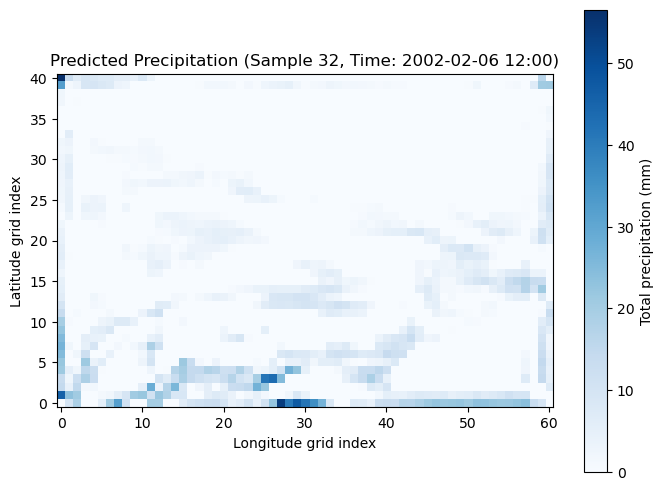

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Select sample index to plot
sample_idx = 32

timestamp = all_times[sample_idx +n_steps_in -1]

pred_to_plot = pred_rainfall_mm[sample_idx]  # shape (lat, lon)

plt.figure(figsize=(8, 6))


plt.imshow(pred_to_plot, origin='lower', cmap='Blues')
plt.colorbar(label='Total precipitation (mm)')
plt.title(f'Predicted Precipitation (Sample {sample_idx}, Time: {pd.to_datetime(timestamp).strftime("%Y-%m-%d %H:%M")})')
plt.xlabel('Longitude grid index')
plt.ylabel('Latitude grid index')
plt.show()


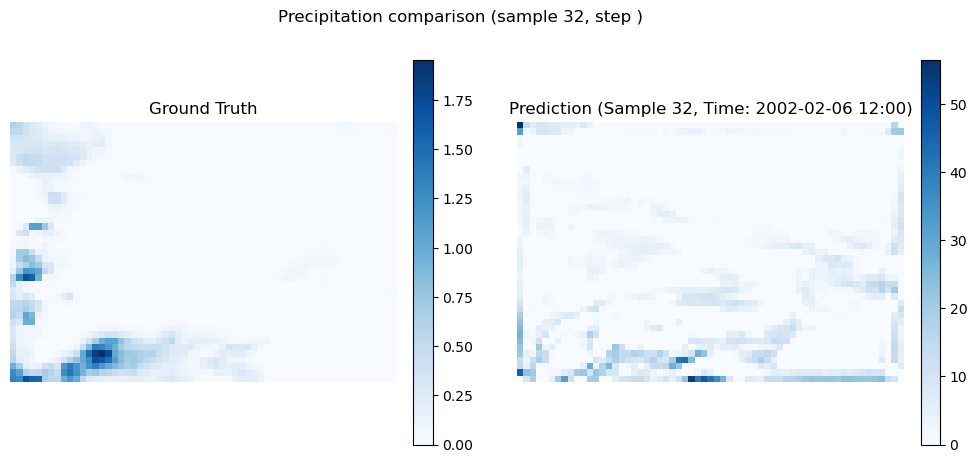

Predictions Normalized - Min: -0.0785047858953476, Max: 0.11688606441020966
Ground Truth Normalized - Min: 0.0, Max: 0.007253502524229091
Predictions Inversed (meters) - Min: -0.07550236582756042, Max: 0.12399136275053024
Ground Truth Inversed (meters) - Min: 0.0, Max: 0.007279872894287109


In [24]:
y_test_reshaped = y_test_normalized.reshape(y_test_normalized.shape[0], num_lat * num_lon)

y_test_inversed = np.expm1(y_test_reshaped)
y_test_inversed = y_test_inversed.reshape(y_test_normalized.shape[0], num_lat, num_lon)

# NEW: Convert y_test_inversed to millimeters and handle negatives
true_rainfall_mm = y_test_inversed * 1000
true_rainfall_mm[true_rainfall_mm < 0] = 0


import matplotlib.pyplot as plt

if n_steps_out == 1:
    pred_to_plot = pred_rainfall_mm[sample_idx]
    true_to_plot = true_rainfall_mm[sample_idx]
else:
    pred_to_plot = pred_rainfall_mm[sample_idx, time_step]
    true_to_plot = true_rainfall_mm[sample_idx, time_step] 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(true_to_plot, origin='lower', cmap='Blues')
axes[0].set_title('Ground Truth')
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(pred_to_plot, origin='lower', cmap='Blues')
axes[1].set_title(f'Prediction (Sample {sample_idx}, Time: {pd.to_datetime(timestamp).strftime("%Y-%m-%d %H:%M")})')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.suptitle(f'Precipitation comparison (sample {sample_idx}, step {time_step if n_steps_out > 1 else ""})')
plt.show()

# In the cell where predictions_normalized is available:
print(f"Predictions Normalized - Min: {predictions_normalized.min()}, Max: {predictions_normalized.max()}")

# In the cell where y_test_normalized is available:
print(f"Ground Truth Normalized - Min: {y_test_normalized.min()}, Max: {y_test_normalized.max()}")

# In the cell with pred_rainfall_mm (before the * 1000 line):
print(f"Predictions Inversed (meters) - Min: {preds_inversed.min()}, Max: {preds_inversed.max()}")

# In the cell with true_rainfall_mm (before the * 1000 line):
print(f"Ground Truth Inversed (meters) - Min: {y_test_inversed.min()}, Max: {y_test_inversed.max()}")


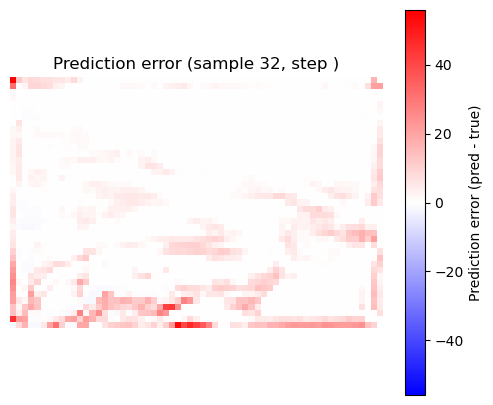

In [25]:
error_map = pred_to_plot - true_to_plot

timestamp = all_times[sample_idx + n_steps_in - 1]

plt.figure(figsize=(6, 5))
plt.imshow(error_map, origin='lower', cmap='bwr', vmin=-abs(error_map).max(), vmax=abs(error_map).max())
plt.colorbar(label='Prediction error (pred - true)')
plt.title(f'Prediction error (sample {sample_idx}, step {time_step if n_steps_out > 1 else ""})')
plt.axis('off')
plt.show()
